# Biodiversity Intactness Index for Phoenix 

## About the notebook

**Link to *my* Biodiversity Intactness Index GitHub repository:**

https://github.com/YoselynR/EDS220-Biodiversity-Intactness-Index

## Purpose 

The purpose of this notebook is to analyze the Biodivesity Intactness Index for the years 2017 and 2020 for the Phoenix subdivision, by looking at the difference in biodiversity index that is >= 0.75. 

## Highlights
- Loading shapefile and BII rasters
- Masking the rasters based on the shapefile geometry
- Ensuring the CRS of the shapefile and rasters are consistent
- Plotting the Phoenix subdivision and the masked BII rasters
- Identifying and visualizing areas of biodiversity loss

## About the data

In this task you will use three datasets: which include the shapefile for the Phoenix subdivision, and the BII data. 

U.S. Census Bureau. (2020). Shapefiles: County subdivisions (2020). U.S. Census Bureau. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions

Microsoft. (n.d.). IO-Biodiversity [Data set]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/io-biodiversity

### First dataset: Phoenix subdivision

The dataset for the Phoenix subdivision is from [Census.gov](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions) in which the state Arizona was selected from the dropdown menu. From the AZ shapefile the Phoenix subdivision was selected from Maricopa County and saved as phoenix_subdivision.shp.

### Second dataset: BII 2017

The datset for BII was downloaded from a stac file available at [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity), once opened the date range Jan 1 2017 to December 31 2017 and coordinates -112.826843, 32.974108, -111.184387, 33.863574 were selected.

### Third dataset: BII 2020

The datset for BII was downloaded from a stac file available at [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity), once opened the date range Jan 1 2020 to December 31 2020 and coordinates -112.826843, 32.974108, -111.184387, 33.863574 were selected.

## <u>Part 1</u>
- Access stac data and save BII for 2017 and 2020
- Load in AZ shapefile and save Phoenix subdivision shapefile

## <u>Part 2</u>
- Mask BII data for 2017 and 2020 to the Phoenix subdivision
- Map Phoenix
- Plot Mask BII data for 2017 and 2020

## <u>Part 3</u>
- Find percentage change of biodiverity from 2017 to 2020
- Plot change of BII
- Plot areas of change over 2020 biodiversity

### Libraries

In [2]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import rioxarray as rioxr
import planetary_computer 
from rasterio.mask import mask
from shapely.geometry import mapping
from pystac_client import Client
from IPython.display import Image 

## <u>Part 1</u>
## Access necessary data and save

### BII data for 2017

In [ ]:
# Temporal range of interest
time_range_17 = "2017-01-01/2017-12-31"

# NCEAS bounding box (as a GeoJSON Polygon)
bbox_phoenix = {
    "type": "Polygon",
    "coordinates": [
        [
            [-112.826843, 32.974108],  # Lower-left corner
            [-111.184387, 32.974108],  # Lower-right corner
            [-111.184387, 33.863574],  # Upper-right corner
            [-112.826843, 33.863574],  # Upper-left corner
            [-112.826843, 32.974108]   # Closing the loop (same as the first point)
        ]
    ]
}

# Catalog search
year_17 = catalog.search(
    collections=['io-biodiversity'],
    intersects=bbox_phoenix,
    datetime=time_range_17
)

# Output the search results
year_17

In [ ]:
# Retrieve search items
item_17 = year_17.item_collection()
item_17

In [ ]:
# Get first item in the catalog search
item_17 = item_17[0]
type(item_17)

In [ ]:
# Print item ID and properties
print('ID:' , item_17.id)
item_17.properties

In [ ]:
# First link will download necessary data that can be saved
item_17.assets

In [ ]:
# Optional
# Plot rendered preview
Image(url=item_17.assets['rendered_preview'].href, width=500)

### BII data for 2020

In [ ]:
# Temporal range of interest
time_range_20 = "2020-01-01/2020-12-31"

# NCEAS bounding box (as a GeoJSON Polygon)
bbox_phoenix = {
    "type": "Polygon",
    "coordinates": [
        [
            [-112.826843, 32.974108],  # Lower-left corner
            [-111.184387, 32.974108],  # Lower-right corner
            [-111.184387, 33.863574],  # Upper-right corner
            [-112.826843, 33.863574],  # Upper-left corner
            [-112.826843, 32.974108]   # Closing the loop (same as the first point)
        ]
    ]
}

# Catalog search
year_20 = catalog.search(
    collections=['io-biodiversity'],
    intersects=bbox_phoenix,
    datetime=time_range_20
)

# Output the search results
year_20

In [ ]:
# Retrieve search items
item_20 = year_20.item_collection()
item_20

In [ ]:
# Get first item in the catalog search
item_20 = item_20[0]
type(item_20)

In [ ]:
# Print item ID and properties
print('ID:' , item_20.id)
item_20.properties

In [ ]:
# First link will download necessary data that can be saved
item_20.assets

In [ ]:
# Optional
# Plot rendered preview
Image(url=item_20.assets['rendered_preview'].href, width=500)

### Save Phoenix subdivision shapefile

In [ ]:
# Load in the Arizona shapefile
az_shapefile = gpd.read_file("data/tl_2020_04_cousub/tl_2020_04_cousub.shp")
# Inspect the columns in the shapefile to understand its structure
print(az_shapefile.columns)
# Filter for the Phoenix subdivision (Phoenix usually has the name "Phoenix" in the NAME or similar column)
county_subdivision = az_shapefile[az_shapefile['COUNTYFP'] == '013']
phoenix_subdivision = county_subdivision[county_subdivision['NAME'].str.contains("Phoenix")]
# Verify the result
print(phoenix_subdivision)
# Optionally, save the Phoenix subdivision shapefile if needed for later use
phoenix_subdivision.to_file("data/phoenix_subdivision.shp")

## <u>Part 2</u>

## Map Phoenix and BII rasters

### Load in data, convert crs, and mask

In [3]:
# Load in the Phoenix subdivision shapefile
phoenix_shapefile = gpd.read_file("data/phoenix_subdivision.shp")
# Extract the geometry of the first feature
phoenix_geometry = phoenix_shapefile.geometry.values[0]

# Load in the BII rasters for 2017 and 2020
bii_2017_path = "data/bii_2017_34.74464974521749_-115.38597824385106_cog.tif"
bii_2020_path = "data/bii_2020_34.74464974521749_-115.38597824385106_cog.tif"

In [4]:
# Convert geometry to GeoJSON-like dict format required by rasterio.mask
geometry = [phoenix_geometry.__geo_interface__]

# Open the 2017 BII raster
with rasterio.open(bii_2017_path) as src_2017:
    bii_2017_data, out_transform = mask(src_2017, geometry, crop=True)
    bii_2017_meta = src_2017.meta  # Metadata for the raster
    raster_crs = src_2017.crs  # Get CRS from the raster file

# Open the 2020 BII raster
with rasterio.open(bii_2020_path) as src_2020:
    bii_2020_data, out_transform = mask(src_2020, geometry, crop=True)
    bii_2020_meta = src_2020.meta
    raster_crs = src_2020.crs  # Get CRS from the raster file

# Print CRS
print(f"CRS of 2017 BII raster: {raster_crs}")
print(f"CRS of 2017 BII raster: {raster_crs}")

CRS of 2017 BII raster: EPSG:4326
CRS of 2017 BII raster: EPSG:4326


In [5]:
# Get shapefile crs and print
shapefile_crs = phoenix_shapefile.crs
print(f"CRS of Phoenix shapefile: {shapefile_crs}")
# Reproject shapefile CRS to match raster CRS if not already the same
if shapefile_crs != 'EPSG:4326':
    phoenix_shapefile = phoenix_shapefile.to_crs(epsg=4326)
    print(f"Reprojected shapefile CRS to: EPSG:4326")

CRS of Phoenix shapefile: EPSG:4269
Reprojected shapefile CRS to: EPSG:4326


### Plot

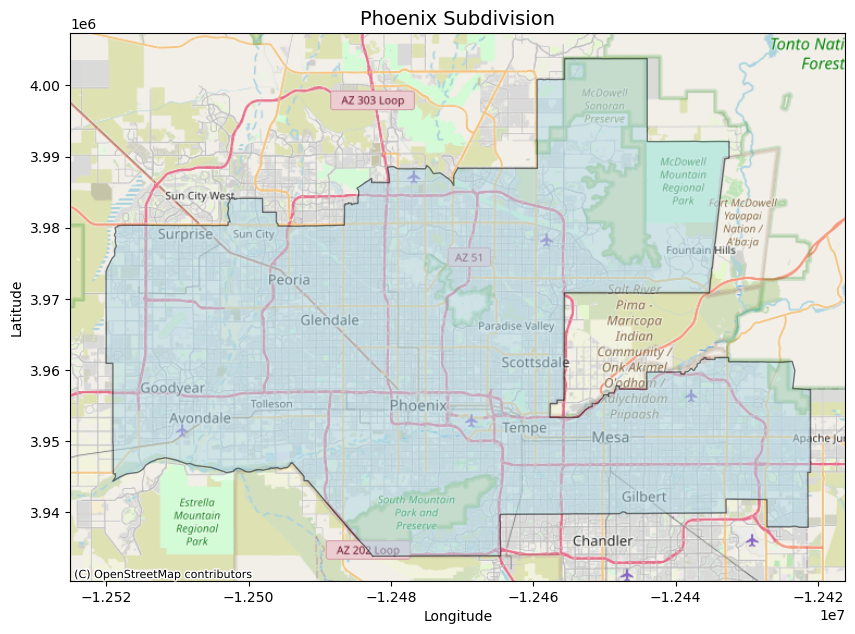

In [31]:
# Reproject Phoenix shapefile for mapping with ctx
phoenix_shapefile_ctx = phoenix_shapefile.to_crs(epsg=3857)
# Plot the Phoenix subdivision
fig, ax = plt.subplots(figsize=(10, 10)) # Larger plot for better readability
phoenix_shapefile_ctx.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
# Base map
ctx.add_basemap(ax, 
                crs=phoenix_shapefile_ctx.crs.to_string(), 
                source=ctx.providers.OpenStreetMap.Mapnik) # Open streetmap
# Add title and labels
ax.set_title("Phoenix Subdivision", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# Show the plot
plt.show()

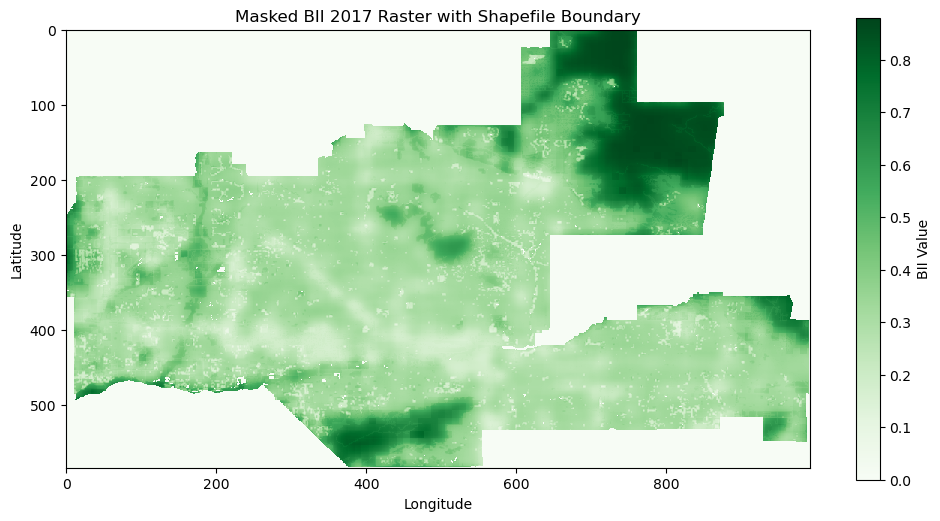

In [30]:
# Plotting the masked raster using Matplotlib
plt.figure(figsize=(12, 6)) # Figure size 
# Plot the 2017 masked raster
plt.imshow(bii_2017_data[0], cmap='Greens', interpolation='none') # Greens for color map
plt.colorbar(label='BII Value') # Color bar for reference
# Add title and labels
plt.title("Masked BII 2017 Raster with Shapefile Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Show the plot
plt.show()

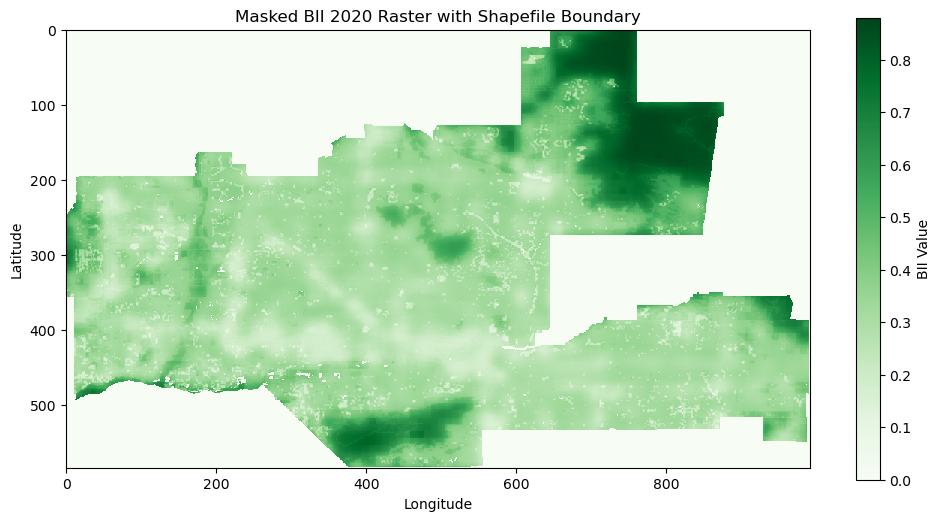

In [29]:
# Plotting the masked raster using Matplotlib
plt.figure(figsize=(12, 6)) # Figure size 
# Plot the 2020 masked raster
plt.imshow(bii_2020_data[0], cmap='Greens', interpolation='none') # Greens for color map
plt.colorbar(label='BII Value') # Color bar for reference
# Add title and labels
plt.title("Masked BII 2020 Raster with Shapefile Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Show the plot
plt.show()

## <u>Part 3</u>

## Map change in Biodiveristy Intactness Index

### Calculate percentage of biodiversity >= 0.75 from 2017 to 2020

In [21]:
# Set threshold
threshold = 0.75
# Find areas >= to threshold
bii_2017 = bii_2017_data[0] >= threshold
bii_2020 = bii_2020_data[0] >= threshold

In [22]:
# Determine total pixels of mask
valid_pixels = np.isfinite(bii_2017_data[0])
# Determine total pixels at threshold
valid_bii_2017_pixels = bii_2017 & valid_pixels
valid_bii_2020_pixels = bii_2020 & valid_pixels
# Sum of total pixels at threshold for 2017 and 2020
pixels_2017 = np.sum(valid_bii_2017_pixels)
pixels_2020 = np.sum(valid_bii_2020_pixels)
# Sum of total pixels
total_valid_pixels = np.sum(valid_pixels)
# Calculate percentage
percentage_2017 = (masked_pixels_2017 / total_valid_pixels) * 100
percentage_2020 = (masked_pixels_2020 / total_valid_pixels) * 100
# Difference of percentage
percentage_difference = percentage_2017 - percentage_2020
# Print
print(f"Percentage of Phoenix area in 2017 with BII >= 0.75: {percentage_2017:.2f}%")
print(f"Percentage of Phoenix area in 2020 with BII >= 0.75: {percentage_2020:.2f}%")
print(f"Percentage of Phoenix area in 2020 with BII >= 0.75: {percentage_difference:.2f}%")

Percentage of Phoenix area in 2017 with BII >= 0.75: 4.17%
Percentage of Phoenix area in 2020 with BII >= 0.75: 3.80%
Percentage of Phoenix area in 2020 with BII >= 0.75: 0.37%


### Plot

(-0.5, 991.5, 583.5, -0.5)

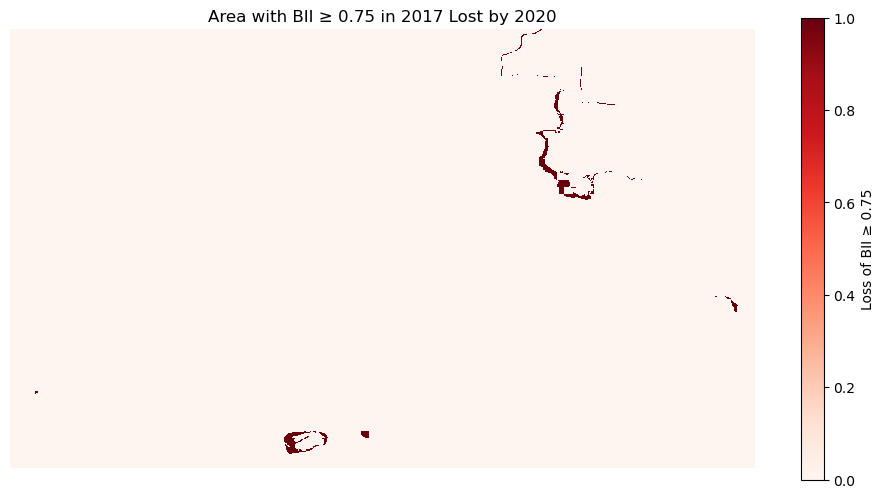

In [25]:
# Identify areas with BII ≥ 0.75 in 2017 that have lost that condition by 2020
bii_total_loss = (bii_mask_2017 == 1) & (bii_mask_2020 == 0)

# Plot the result
plt.figure(figsize=(12, 6)) # Figure size
plt.imshow(bii_total_loss, cmap='Reds', interpolation='nearest') # Reds for color
plt.title("Area with BII ≥ 0.75 in 2017 Lost by 2020") # Title
plt.colorbar(label="Loss of BII ≥ 0.75") # Color bar for reference
plt.axis('off')

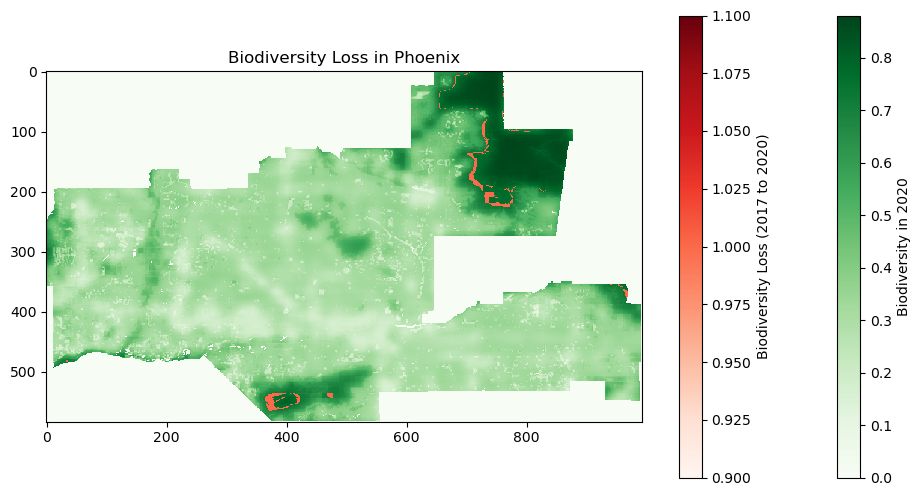

In [27]:
# Prepare loss mask
total_loss_mask = np.where(bii_total_loss, 1, np.nan) # Mask to plot overlay

# Plot base layer
plt.figure(figsize=(12, 6)) # Figure size
plt.imshow(bii_2020_data[0], 
           cmap="Greens", # Greens for biodiversity
           interpolation="none", 
           label="Biodiversity Intactness (2020)")
plt.colorbar(label="Biodiversity in 2020")
# Plot 
plt.imshow(total_loss_mask, 
           cmap="Reds", 
           interpolation="nearest") # Reds for loss
plt.colorbar(label="Biodiversity Loss (2017 to 2020)")
plt.title("Biodiversity Loss in Phoenix")
plt.show()